# Fine-Tuning Pipeline

In [1]:
import pandas as pd
import numpy as np
import random
import time
import datetime
import torch
## Torch Modules
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
## PyTorch Transformer
from transformers import RobertaModel, RobertaTokenizer
from transformers import RobertaForSequenceClassification, RobertaConfig
from torchnlp.encoders import LabelEncoder
from torch.utils.data import TensorDataset, random_split
from transformers import get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from sklearn.metrics import accuracy_score

In [2]:
torch.manual_seed(42)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

import numpy as np
np.random.seed(69)


In [3]:
# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla V100-PCIE-16GB


In [4]:
#@title

def clean_text(text):
    import re
    #from nltk.corpus import stopwords

    REPLACE_BY_SPACE_RE = re.compile('[.#+_/(){}\[\]\|@,;-]')
    BAD_SYMBOLS_RE = re.compile('[^0-9a-z +_]')
    #STOPWORDS = set(stopwords.words('english'))
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing.
    
    """
    try:
        return text.replace(re.findall(r'(\d{5,10})', text)[0],'') # remove pincodes mentioned in address if exists
    except:
        return text
    
    """
    return text

In [5]:
def run_clean_address(df,col_name): #given raw address column, clean address and output term frequency dataframe
    
    import re

    addresses = df[col_name].map(lambda x: ' '.join(re.split('(\d+)',x)))
    #addresses = addresses.map(lambda x: re.sub(r"([0-9]+(\.[0-9]+)?)",r" \1 ", x).strip())
    
    addresses = addresses.apply(clean_text)
    #addresses = addresses.map(lambda x : re.sub(r'\b\w{1,5}\b', '', x) ) #hyperparameter : removing tokens which are not very long

    df["address_tokens"] = addresses.str.split()
    df["address_clean"] = df["address_tokens"].map(lambda x: ' '.join(x))
    
    return df

In [6]:
pwd

'/data/home/deploy/shreyas/fine-tuning_exp'

In [7]:
ls

BERT_Address_Classifier_Faridabad.ipynb
model_combinedBertBLGRWHF/
model_combinedBertFAR/
model_combinedBertNDA/
model_DelhiNCR_PreTrained_BertFAR/
model_prepropcombinedBertFAR/
model_prepropcombinedBertWHF/
model_wikiBertBLGRWHF/
model_wikiBertDELFAR/
model_wikiBertDELNDA/
preprop_RoBERTa_Address_Classifier_Finetuning-BLR-WHF.ipynb
preprop_RoBERTa_Address_Classifier_Finetuning-FAR.ipynb
RoBERTa_Address_Classifier_Finetuning-FAR.ipynb
RoBERTa_Address_Classifier_Finetuning.ipynb
RoBERTa_Address_Classifier_Finetuning-NDA.ipynb
RoBERTa_Address_Classifier_Finetuning-WHF.ipynb
RoBERTa_Pre-Trained_On_Only_Delhi_NCR_Address_Classifier_Finetuning-DELHI-NCR-FAR.ipynb
Untitled.ipynb
Wiki-RoBERTa_Address_Classifier-BLD.ipynb
Wiki-RoBERTa_Address_Classifier-FAR.ipynb
Wiki-RoBERTa_Address_Classifier-NDA.ipynb
Wiki-RoBERTa_Address_Classifier-WHF.ipynb


In [11]:
train_df = pd.read_csv('/home/deploy/shreyas/addressData/BLD/BLD_address_train_BERT.csv')
print("done")

# Report the number of sentences.
print('Number of train_df sentences: {:,}\n'.format(train_df.shape[0]))

done
Number of train_df sentences: 75,424



In [12]:
train_df.head()

id                                            address  \
0  402206520  Flat No. 604, Bolck E, Bren Celestia Apartment...   
1  402200244  SJR veriety,viva406, kasavanahalli, near lacas...   
2  402199980  Flat 305, Shri Paradise Apartment,Boganahalli ...   
3  402188672  9th Floor, Shakti Statesman, Green Glen Layout...   
4  402177932  Shivani Sunshine No11 and 12 Anasara Central j...   

                                       address_clean  \
0  flat no 604 bolck e bren celestia apartment ka...   
1  sjr veriety viva 406 kasavanahalli near lacasa...   
2  flat 305 shri paradise apartment boganahalli m...   
3  9 th floor shakti statesman green glen layout ...   
4  shivani sunshine no 11 and 12 anasara central ...   

                               address_clean_preprop route_id  
0  flat no 604 bolck e bren celestia apartment ka...      r22  
1  sjr verity viva 406 kasavanahalli near lacasa ...      r27  
2  flat 305 shri paradise apartment boganahalli m...      r14  
3  9 th floor shakti statesman green glen layout ...       r4  
4  shivani sunshine no 11 and 12 anasara central ...      r28

In [54]:
train_df.iloc[9]['address_clean']

'room 205 raghavendra studio rooms above star bazar near sakra world hospital outer ring road bellandur 560103'

In [13]:
test_df = pd.read_csv('/home/deploy/shreyas/addressData/BLD/BLD_address_test_BERT.csv')
print("done")

# Report the number of sentences.
print('Number of test_df sentences: {:,}\n'.format(test_df.shape[0]))

done
Number of test_df sentences: 23,444



In [14]:
test_df.head()

id                                            address  \
0  416650968  C block 404 , Isha Casablanca,  Panathur Railw...   
1  416650898  415- A Block SLS Sapphire Apartment Boganhalli...   
2  416650886        10th Cross, Bellandur, bengaluru, Bellandur   
3  416650848  Sai Nidhi, Sainidhi Apartment, 4th Vijayakumar...   
4  416650718  Sreeda Pride, B-303, Owners Court East Layout ...   

                                       address_clean  \
0  c block 404 isha casablanca panathur railway s...   
1  415 a block sls sapphire apartment boganhalli ...   
2   10 th cross bellandur bengaluru bellandur 560103   
3  sai nidhi sainidhi apartment 4 th vijayakumar ...   
4  sreeda pride b 303 owners court east layout ro...   

                               address_clean_preprop route_id  
0  c block 404 isha casablanca panathur railway s...      r36  
1  415 a block sls sapphire apartment boganahalli...      r14  
2             10 th cross bengaluru bellandur 560103       r4  
3  sai nidhi sannidhi apartment 4 th vijaya kumar...      r31  
4  sreeda pride b 303 owners court east layout ro...      r28

## Fine-tuning using address cleaned in the same way as in pre-training without probabilistic cleaning steps

In [15]:
#dataset = train_df.append(test_df, ignore_index=True)

In [16]:
sentences = train_df.address_clean.values
labels = train_df.route_id.values

encoder = LabelEncoder(labels)
labels = encoder.batch_encode(train_df.route_id.values)

In [17]:
num_classes = len(encoder.vocab)
print("num_classes including 'unk' ", len(labels.unique()))


num_classes including 'unk'  41


# Loading standard tokenizer RoBERTa

In [18]:
from transformers import RobertaTokenizer
from transformers import RobertaForSequenceClassification


In [19]:
config = RobertaConfig.from_pretrained('distilroberta-base')
config.num_labels = num_classes
config

RobertaConfig {
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12",
    "13": "LABEL_13",
    "14": "LABEL_14",
    "15": "LABEL_15",
    "16": "LABEL_16",
    "17": "LABEL_17",
    "18": "LABEL_18",
    "19": "LABEL_19",
    "20": "LABEL_20",
    "21": "LABEL_21",
    "22": "LABEL_22",
    "23": "LABEL_23",
    "24": "LABEL_24",
    "25": "LABEL_25",
    "26": "LABEL_26",
    "27": "LABEL_27",
    "28": "LABEL_28",
    "29": "LABEL_29",
    "30": "LABEL_30",
    "31": "LABEL_31",
    "32": "LABEL_32",
    "33": "LABEL_33",
    "34": "LABEL_34",
    "35": 

In [20]:
tokenizer = RobertaTokenizer.from_pretrained('distilroberta-base')
model = RobertaForSequenceClassification(config)

print("done")

done


In [21]:
max_len = 0

# For every sentence...

for sent in sentences:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Max sentence length:  87


In [22]:
# Print the original sentence.
print(' Original: ', sentences[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(sentences[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

 Original:  flat no 604 bolck e bren celestia apartment kaikondrahalli behind reliance digital bengaluru 560035
Tokenized:  ['flat', 'Ġno', 'Ġ6', '04', 'Ġbol', 'ck', 'Ġe', 'Ġb', 'ren', 'Ġcel', 'est', 'ia', 'Ġapartment', 'Ġka', 'ik', 'ond', 'rah', 'alli', 'Ġbehind', 'Ġreliance', 'Ġdigital', 'Ġb', 'eng', 'al', 'uru', 'Ġ56', '00', '35']
Token IDs:  [35429, 117, 231, 3387, 24724, 2420, 364, 741, 2558, 15054, 990, 493, 3537, 4661, 967, 2832, 9772, 19273, 639, 14197, 1778, 741, 3314, 337, 5515, 4772, 612, 2022]


In [23]:
model.cuda(device)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm

In [24]:
# Tokenize all of the sentences and map the tokens to their word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = max_len,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
#labels = torch.tensor(labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

Original:  flat no 604 bolck e bren celestia apartment kaikondrahalli behind reliance digital bengaluru 560035
Token IDs: tensor([    0,  3269,   117,   231,  3387, 24724,  2420,   364,   741,  2558,
        15054,   990,   493,  3537,  4661,   967,  2832,  9772, 19273,   639,
        14197,  1778,   741,  3314,   337,  5515,  4772,   612,  2022,     2,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1])


In [25]:
# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.99 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

74,669 training samples
  755 validation samples


In [26]:
# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [27]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 107 different named parameters.

==== Embedding Layer ====

roberta.embeddings.word_embeddings.weight               (50265, 768)
roberta.embeddings.position_embeddings.weight             (514, 768)
roberta.embeddings.token_type_embeddings.weight             (1, 768)
roberta.embeddings.LayerNorm.weight                           (768,)
roberta.embeddings.LayerNorm.bias                             (768,)

==== First Transformer ====

roberta.encoder.layer.0.attention.self.query.weight       (768, 768)
roberta.encoder.layer.0.attention.self.query.bias             (768,)
roberta.encoder.layer.0.attention.self.key.weight         (768, 768)
roberta.encoder.layer.0.attention.self.key.bias               (768,)
roberta.encoder.layer.0.attention.self.value.weight       (768, 768)
roberta.encoder.layer.0.attention.self.value.bias             (768,)
roberta.encoder.layer.0.attention.output.dense.weight     (768, 768)
roberta.encoder.layer.0.attention.output.dense.bias           (

In [28]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"

from transformers import AdamW

optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )


In [29]:


# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 4

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [30]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [31]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


# Roberta Fine-Tuning 

In [32]:
# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        loss, logits = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            (loss, logits) = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...


/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha)


  Batch    40  of  2,334.    Elapsed: 0:00:04.
  Batch    80  of  2,334.    Elapsed: 0:00:08.
  Batch   120  of  2,334.    Elapsed: 0:00:12.
  Batch   160  of  2,334.    Elapsed: 0:00:16.
  Batch   200  of  2,334.    Elapsed: 0:00:20.
  Batch   240  of  2,334.    Elapsed: 0:00:24.
  Batch   280  of  2,334.    Elapsed: 0:00:28.
  Batch   320  of  2,334.    Elapsed: 0:00:32.
  Batch   360  of  2,334.    Elapsed: 0:00:36.
  Batch   400  of  2,334.    Elapsed: 0:00:40.
  Batch   440  of  2,334.    Elapsed: 0:00:44.
  Batch   480  of  2,334.    Elapsed: 0:00:48.
  Batch   520  of  2,334.    Elapsed: 0:00:52.
  Batch   560  of  2,334.    Elapsed: 0:00:56.
  Batch   600  of  2,334.    Elapsed: 0:01:00.
  Batch   640  of  2,334.    Elapsed: 0:01:04.
  Batch   680  of  2,334.    Elapsed: 0:01:08.
  Batch   720  of  2,334.    Elapsed: 0:01:12.
  Batch   760  of  2,334.    Elapsed: 0:01:16.
  Batch   800  of  2,334.    Elapsed: 0:01:20.
  Batch   840  of  2,334.    Elapsed: 0:01:24.
  Batch   880

  Batch 2,040  of  2,334.    Elapsed: 0:03:54.
  Batch 2,080  of  2,334.    Elapsed: 0:04:02.
  Batch 2,120  of  2,334.    Elapsed: 0:04:09.
  Batch 2,160  of  2,334.    Elapsed: 0:04:17.
  Batch 2,200  of  2,334.    Elapsed: 0:04:29.
  Batch 2,240  of  2,334.    Elapsed: 0:04:41.
  Batch 2,280  of  2,334.    Elapsed: 0:04:52.
  Batch 2,320  of  2,334.    Elapsed: 0:05:04.

  Average training loss: 0.51
  Training epcoh took: 0:05:08

Running Validation...
  Accuracy: 0.86
  Validation Loss: 0.53
  Validation took: 0:00:02

======== Epoch 4 / 4 ========
Training...
  Batch    40  of  2,334.    Elapsed: 0:00:12.
  Batch    80  of  2,334.    Elapsed: 0:00:23.
  Batch   120  of  2,334.    Elapsed: 0:00:35.
  Batch   160  of  2,334.    Elapsed: 0:00:50.
  Batch   200  of  2,334.    Elapsed: 0:01:06.
  Batch   240  of  2,334.    Elapsed: 0:01:22.
  Batch   280  of  2,334.    Elapsed: 0:01:37.
  Batch   320  of  2,334.    Elapsed: 0:01:53.
  Batch   360  of  2,334.    Elapsed: 0:02:08.
  Bat

In [33]:
training_stats

[{'epoch': 1,
  'Training Loss': 1.3040942609974127,
  'Valid. Loss': 0.6641975194215775,
  'Valid. Accur.': 0.8228481359649122,
  'Training Time': '0:03:57',
  'Validation Time': '0:00:01'},
 {'epoch': 2,
  'Training Loss': 0.621476688889121,
  'Valid. Loss': 0.5505926758050919,
  'Valid. Accur.': 0.8527960526315789,
  'Training Time': '0:03:58',
  'Validation Time': '0:00:01'},
 {'epoch': 3,
  'Training Loss': 0.511980221326676,
  'Valid. Loss': 0.5274898105611404,
  'Valid. Accur.': 0.8601973684210527,
  'Training Time': '0:05:08',
  'Validation Time': '0:00:02'},
 {'epoch': 4,
  'Training Loss': 0.4529164577830318,
  'Valid. Loss': 0.5080216880887747,
  'Valid. Accur.': 0.8667077850877193,
  'Training Time': '0:14:55',
  'Validation Time': '0:00:03'}]

In [34]:
pwd

'/data/home/deploy/shreyas/fine-tuning_exp'

# Model Saving

In [35]:
import os

# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './model_wikiBertDELNDA/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
#torch.save(args, os.path.join(output_dir, 'training_args.bin'))


Saving model to ./model_wikiBertDELNDA/


('./model_wikiBertDELNDA/vocab.json',
 './model_wikiBertDELNDA/merges.txt',
 './model_wikiBertDELNDA/special_tokens_map.json',
 './model_wikiBertDELNDA/added_tokens.json')

In [36]:
type(model)

transformers.modeling_roberta.RobertaForSequenceClassification

In [37]:
ls

BERT_Address_Classifier_Faridabad.ipynb
model_combinedBertBLGRWHF/
model_combinedBertFAR/
model_combinedBertNDA/
model_DelhiNCR_PreTrained_BertFAR/
model_prepropcombinedBertFAR/
model_prepropcombinedBertWHF/
model_wikiBertBLGRWHF/
model_wikiBertDELFAR/
model_wikiBertDELNDA/
preprop_RoBERTa_Address_Classifier_Finetuning-BLD.ipynb
preprop_RoBERTa_Address_Classifier_Finetuning-BLR-WHF.ipynb
preprop_RoBERTa_Address_Classifier_Finetuning-FAR.ipynb
preprop_RoBERTa_Address_Classifier_Finetuning-NDA.ipynb
RoBERTa_Address_Classifier_Finetuning-BLD.ipynb
RoBERTa_Address_Classifier_Finetuning-FAR.ipynb
RoBERTa_Address_Classifier_Finetuning.ipynb
RoBERTa_Address_Classifier_Finetuning-NDA.ipynb
RoBERTa_Address_Classifier_Finetuning-WHF.ipynb
RoBERTa_Pre-Trained_On_Only_Delhi_NCR_Address_Classifier_Finetuning-DELHI-NCR-FAR.ipynb
Untitled.ipynb
Wiki-RoBERTa_Address_Classifier-BLD.ipynb
Wiki-RoBERTa_Address_Classifier-FAR.ipynb
Wiki-RoBERTa_Address_Classifier-NDA.ipynb
Wiki-RoBERTa_Address_Classifier-

# Evaluation on Hidden Test Set

In [38]:
import pandas as pd

# Load the dataset into a pandas dataframe.

# Report the number of sentences.
print('Number of test addresses: {:,}\n'.format(test_df.shape[0]))

# Create sentence and label lists
sentences = test_df.address_clean.values
labels = test_df.route_id.values

labels = encoder.batch_encode(test_df.route_id.values)



# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Set the batch size.  
batch_size = 64  

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Number of test addresses: 23,444



/home/deploy/.conda/envs/shreyasvenv/lib/python3.6/site-packages/ipykernel_launcher.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [39]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels, pred_labels, confidence = [], [], [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]


  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  pred_labels_batch = [np.argmax(i) for i in logits]
  confidence_batch = [torch.nn.functional.softmax(torch.FloatTensor(np.array(i).reshape(1,-1))).numpy().max() for i in logits]
    

  
  # Store predictions and true labels
  predictions.append(logits)
  pred_labels.append(pred_labels_batch)
  true_labels.append(label_ids)
  confidence.append(confidence_batch)

print('    DONE.')

/home/deploy/.conda/envs/shreyasvenv/lib/python3.6/site-packages/ipykernel_launcher.py:34: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Predicting labels for 23,444 test sentences...
    DONE.


In [40]:
pred_labels_flat = [item for sublist in pred_labels for item in sublist]
true_labels_flat = [item for sublist in true_labels for item in sublist]
confidence_flat = [item for sublist in confidence for item in sublist]

In [41]:
accuracy_score(pred_labels_flat,true_labels_flat)

0.9053062617300802

In [42]:
test = pd.DataFrame({"id":test_df['id'].values,"address":test_df['address'],'address_clean':test_df['address_clean'],'address_clean_preprop':test_df['address_clean_preprop'],"route_id":encoder.batch_decode(torch.IntTensor(true_labels_flat)),"pred_route_id":encoder.batch_decode(torch.IntTensor(pred_labels_flat)),"confidence_score":confidence_flat})
print("done")


done


In [43]:
test.loc[test["confidence_score"]<=test.confidence_score.quantile(0.1),"quantile"]=test.confidence_score.quantile(0.1)
test.loc[(test["confidence_score"]>test.confidence_score.quantile(0.1))&(test["confidence_score"]<=test.confidence_score.quantile(0.2)),"quantile"]=test.confidence_score.quantile(0.2)
test.loc[(test["confidence_score"]>test.confidence_score.quantile(0.2))&(test["confidence_score"]<=test.confidence_score.quantile(0.3)),"quantile"]=test.confidence_score.quantile(0.3)
test.loc[(test["confidence_score"]>test.confidence_score.quantile(0.3))&(test["confidence_score"]<=test.confidence_score.quantile(0.4)),"quantile"]=test.confidence_score.quantile(0.4)
test.loc[(test["confidence_score"]>test.confidence_score.quantile(0.4))&(test["confidence_score"]<=test.confidence_score.quantile(0.5)),"quantile"]=test.confidence_score.quantile(0.5)
test.loc[(test["confidence_score"]>test.confidence_score.quantile(0.5))&(test["confidence_score"]<=test.confidence_score.quantile(0.6)),"quantile"]=test.confidence_score.quantile(0.6)
test.loc[(test["confidence_score"]>test.confidence_score.quantile(0.6))&(test["confidence_score"]<=test.confidence_score.quantile(0.7)),"quantile"]=test.confidence_score.quantile(0.7)
test.loc[(test["confidence_score"]>test.confidence_score.quantile(0.7))&(test["confidence_score"]<=test.confidence_score.quantile(0.8)),"quantile"]=test.confidence_score.quantile(0.8)
test.loc[(test["confidence_score"]>test.confidence_score.quantile(0.8))&(test["confidence_score"]<=test.confidence_score.quantile(0.9)),"quantile"]=test.confidence_score.quantile(0.9)
test.loc[(test["confidence_score"]>test.confidence_score.quantile(0.9)),"quantile"]=test.confidence_score.quantile(1.0)




In [44]:
q=test["quantile"].unique().tolist()
q.sort()
print(q)

acc_vs_confidence_plot = pd.DataFrame({"quantile":q,"accuracy":np.zeros(len(test["quantile"].unique())),"support":np.zeros(len(test["quantile"].unique()))})


[0.6313505411148072, 0.7762495517730713, 0.8984431505203248, 0.9577690243721009, 0.9796228408813477, 0.988192081451416, 0.9920763373374939, 0.9945194602012635, 0.9961988508701325, 0.9987218976020813]


In [45]:
for i in range(len(acc_vs_confidence_plot)):
    acc_vs_confidence_plot.at[i, 'accuracy'] = len(test.loc[(test["quantile"]==acc_vs_confidence_plot["quantile"].iloc[i])&(test["route_id"]==test["pred_route_id"])])/float(len(test.loc[test["quantile"]==acc_vs_confidence_plot["quantile"].iloc[i]]))
    acc_vs_confidence_plot.at[i,"support"] = len(test.loc[test["quantile"]==acc_vs_confidence_plot["quantile"].iloc[i]])


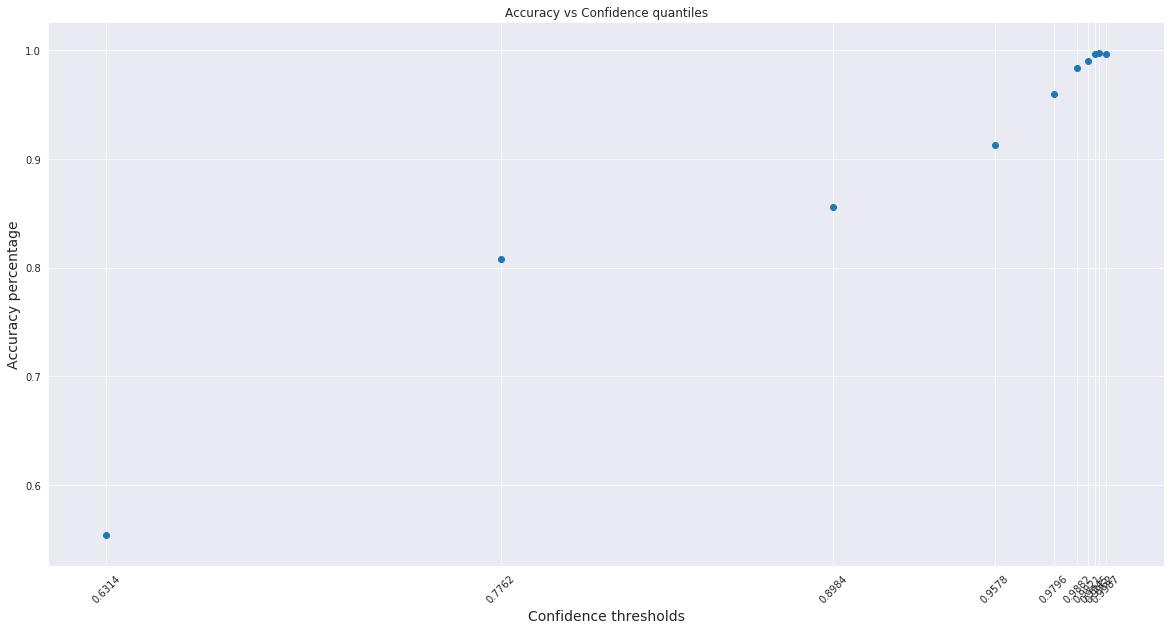

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
#sns.barplot(acc_vs_entropy_plot["quantile"],acc_vs_entropy_plot["accuracy"], alpha=1.0,palette="rocket")
sns.set_style("darkgrid")
plt.scatter(acc_vs_confidence_plot["quantile"],acc_vs_confidence_plot["accuracy"])
plt.xticks(list(acc_vs_confidence_plot["quantile"]),rotation=45)
plt.title('Accuracy vs Confidence quantiles')
plt.ylabel('Accuracy percentage', fontsize=14)
plt.xlabel('Confidence thresholds', fontsize=14)
plt.show()

In [59]:
list(test.loc[(test['confidence_score']>0.99)&(test['pred_route_id']!=test['route_id'])]['address_clean'])

['g 5 ushodaya trinity green glan layout bellandur 560103',
 '353 doddakannahalli colony opp library gear school road camelaram post bangalore doddakannahalli colony 560035',
 '109 sri sri nivasa green glen layout 560103',
 'cosmos tower 13 a klassic landmark kasavanhalli off hosa road kasavanhalli 560035',
 '109 sri sri nivasa green glen layout bellandur 560103',
 '301 heritage homes kasavanahalli 560035',
 'flat no 122 skanda sky apartment gear road kaverappa layout 560103',
 '211 wing 2 sandeep square apartment 560103',
 'hk symphony concert 1402 kasavanahalli opp amrita college bangalore 560035',
 'block 1 d 4 parijatha apartment 2 nd cross in front of friends bakery green glen layout bellanduru 560103',
 '317 b koramangala 8 th block beside tom restaurant 560035',
 'akshay nilaya 4 18 29 th a main jaya bheema nagar btm 1 st stage madiwal bangalore 560103',
 'g 6 sandeep square apt bhoganahalli bellandur back gate to embassy tech village 560103',
 '101 first floor block c habitat i

In [58]:
list(test.loc[(test['confidence_score']<0.6)&(test['pred_route_id']==test['route_id'])]['address_clean'])

['adarsh palm retreat tower 4 e 003 bellandur 560103',
 '32 sri vishnu pg opp chennakesava temple kaikundrahalli bus stop sarjapura road 560035',
 'sir lakshmi narasimha krupa 1 st main 14 th kodandramanagra sarjapur road 560035',
 'villa 641 adarsh palm retreat phase 3 devarabeesanahalli 560103',
 'adarsh palm retreat villas villa 521 lane 1 n phase 3 bellandur 560103',
 'flat no c 1 202 second floor 12 th cross road kasavanahalli 560035',
 'house no 10 pushpaveni layout maruthi nagar near soul spirit inside kanti sweets arch kaikondrahalli 560035',
 'villa 344 adarsh palm retreat bellandur 560103',
 'sy no 103 2 govinda reddy layout kodathi gate sarjapur road carmelaram 560035',
 'flat no 202 building no 331 21 maruthi nagar kaikondrahalli sarjapura main road kaikondrahalli 560035',
 'flat no 303 sharanya arcade kaikondanahalli sarjapur road behind bata showroom bangalore karnataka kaikondrahalli 560035',
 'villa 422 adarsh palm retreat outer ring road belandur 560103',
 'sri rama sr